# **TASK**: to create 2-head neural network for regression and classification tasks

In [1]:
from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, explained_variance_score
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def split_data(X, y_clas, y_regr, test_split):
    ind = int(np.round(len(X) * (1-test_split), 0))
    X_train = X[:ind]; X_test = X[ind:]
    y_train_clas = y_clas[:ind]; y_test_clas = y_clas[ind:]
    y_train_regr = y_regr[:ind]; y_test_regr = y_regr[ind:]
    return X_train, X_test, y_train_clas, y_test_clas, y_train_regr, y_test_regr

In [19]:
class NeuralNetwork(object):
    def __init__(self, param_clas, param_regr, learning_rate, beta):
        
        self.param_clas = param_clas
        self.param_regr = param_regr
        self.type_nn = 'clas'
        
        self.learning_rate = learning_rate
        self.beta = beta
        self.loss_dict_clas_train = []
        self.loss_dict_clas_val = []
        self.loss_dict_regr_train = []
        self.loss_dict_regr_val = []
        self.acc_dict_clas_train = []
        self.acc_dict_clas_val = []
        self.expl_var_train = []
        self.expl_var_val = []
    
    def init_param(self, param_dict):
        W1 = np.random.normal(0, 0.03, (param_dict[0], param_dict[1])) * 10
        b1 = np.ones((param_dict[1], 1))
        W2 = np.random.normal(0, 0.03, (param_dict[1], param_dict[2])) * 10
        b2 = np.ones((param_dict[2], 1))
        W3 = np.random.normal(0, 0.03, (param_dict[2], param_dict[3])) * 10
        b3 = np.ones((param_dict[3], 1))
        return [W1, b1, W2, b2, W3, b3]
    
    def softmax(self, X, deriv = False):
        if (deriv == True):
            return np.array([it * (1 - it) for it in X])
        else:
            exp_X = np.exp(X)
            exp_X_sum = np.sum(exp_X, axis=1).reshape(-1, 1)
            exp_X = (exp_X / exp_X_sum)
            return exp_X
    
    def sigmoid(self, s, deriv=False):
        if (deriv == True):
            return s * (1 - s)
        return 1/(1 + np.exp(-s))
    
    def relu(self, X):
        return np.maximum(0, X)

    def feedForward(self, X, params):
        z1 = np.array(self.sigmoid(np.matmul(X, params[0]) + params[1].T)).reshape(len(X), params[6][1])
        z2 = np.array(self.sigmoid(np.matmul(z1, params[2]) + params[3].T)).reshape(len(X), params[6][2])
        if self.type_nn == 'clas': 
            output = np.array(self.softmax(np.matmul(z2, params[4]) + params[5].T)).reshape(len(X), params[6][3])
        else:
            output = np.array(self.relu(np.matmul(z2, params[4]) + params[5].T)).reshape(len(X), 1)
        return output, [z1, z2]
    
    def backward(self, X, y, output, params, cache):
        output_error = output - y
        A2 = np.multiply(np.matmul((output_error), params[4].T), self.sigmoid(cache[1], deriv = True))
        A1 = np.multiply(np.matmul((A2), params[2].T), self.sigmoid(cache[0], deriv = True))
        
        part_der3 = np.matmul(cache[1].T, output_error) / len(X)
        part_der2 = np.matmul(cache[0].T, A2) / len(X)
        part_der1 = np.matmul(X.T, A1) / len(X)
        
        params[0] -= self.learning_rate * (part_der1 + self.beta * params[0])
        params[2] -= self.learning_rate * (part_der2 + self.beta * params[2])
        params[4] -= self.learning_rate * (part_der3 + self.beta * params[4])
        return params
    
    def calc_loss_acc(self, y, y_pred, data_type):
        acc = 0
        loss = 0
        if self.type_nn == 'clas':
            acc = np.sum(np.argmax(y, axis=1)==np.argmax(y_pred, axis=1)) / len(y)
            loss = self.loss_categorical(y, y_pred)
            if data_type == 'train':
                self.loss_dict_clas_train.append(loss)
                self.acc_dict_clas_train.append(acc)
            else:
                self.loss_dict_clas_val.append(loss)
                self.acc_dict_clas_val.append(acc)
        else:
            loss = mean_squared_error(y, (y_pred)) * 100
            expl_var = explained_variance_score(y, (y_pred))
            if data_type == 'train':
                self.loss_dict_regr_train.append(loss)
                self.expl_var_train.append(expl_var)
            else:
                self.loss_dict_regr_val.append(loss)
                self.expl_var_val.append(expl_var)
    
    def loss_categorical(self, y, y_pred, deriv = False):
        if (deriv == True):
            return y_pred - y
        else:
            return -1 * np.sum(y * np.log(y_pred))
    
    def predict(self, X, type_nn):
        self.type_nn = type_nn
        if type_nn == 'clas':
            output, cache = self.feedForward(X, self.param_clas)
        else:
            output, cache = self.feedForward(X, self.param_regr)
        return output
    
    def plot_metrics(self, plot_dict):
        fig, ax = plt.subplots(figsize=(20,20))
        index = 0
        for i in range(0, len(plot_dict), 2):
            ax = plt.subplot(len(plot_dict) / 2, 2, index+1)
            ax.plot(list(range(plot_dict[str(i+1)]['index'], len(plot_dict[str(i+1)]['plot_x']))), 
                    plot_dict[str(i+1)]['plot_y'], label = plot_dict[str(i+1)]['label'])
            ax.set_xlabel(plot_dict[str(i+1)]['xlabel'])
            ax.set_ylabel(plot_dict[str(i+1)]['ylabel'])
            ax.set_title(plot_dict[str(i+1)]['title'])
            ax.plot(list(range(plot_dict[str(i+1)]['index'],len(plot_dict[str(i+2)]['plot_x']))),
                    plot_dict[str(i+2)]['plot_y'], label = plot_dict[str(i+2)]['label'])
            ax.set_xlabel(plot_dict[str(i+2)]['xlabel'])
            ax.set_ylabel(plot_dict[str(i+2)]['ylabel'])
            ax.set_title(plot_dict[str(i+2)]['title']);
            index += 1
            plt.legend()
        plt.show()
    
    def set_dict(self, metric_dict, index, title, label, xlabel, ylabel):
        plot_dict = dict()
        plot_dict['title'] = title
        plot_dict['xlabel'] = xlabel
        plot_dict['ylabel'] = ylabel
        plot_dict['plot_x'] = metric_dict
        plot_dict['plot_y'] = metric_dict[index:]
        plot_dict['label'] = label
        plot_dict['index'] = index
        return plot_dict

    def plot_graphic(self):
        plot_dict = dict()
        plot_dict['1'] = self.set_dict(self.loss_dict_clas_train, 1, 'Loss classification MSE',
                                       'Train loss clas.', 'Iterations', 'Loss')
        plot_dict['2'] = self.set_dict(self.loss_dict_clas_val, 1, 'Loss classification MSE',
                                       'Validation loss clas.', 'Iterations', 'Loss')
        plot_dict['3'] = self.set_dict(self.acc_dict_clas_train, 1, 'Accuracy classification',
                                       'Train accuracy clas', 'Iterations', 'Accuracy')
        plot_dict['4'] = self.set_dict(self.acc_dict_clas_val, 1, 'Accuracy classification',
                                       'Validation accuracy clas', 'Iterations', 'Accuracy')
        plot_dict['5'] = self.set_dict(self.loss_dict_regr_train, 50, 'Loss regression',
                                       'Train loss regr', 'Iterations', 'Loss')
        plot_dict['6'] = self.set_dict(self.loss_dict_regr_val, 50, 'Loss regression',
                                       'Validation loss regr', 'Iterations', 'Loss')
        plot_dict['7'] = self.set_dict(self.expl_var_train, 1, 'Explained variance regression',
                                       'Train explained variance score regr', 'Iterations', 'Explained variance score')
        plot_dict['8'] = self.set_dict(self.expl_var_val, 1, 'Explained variance regression',
                                       'Validation explained variance score regr', 'Iterations', 'Explained variance score')        
        self.plot_metrics(plot_dict)
    
    def train(self, X_train, y_train, X_val, y_val, param_list, index, iterations = 2):
        for j in range(iterations):
            output, cache = self.feedForward(X_train, param_list)
            param_list = self.backward(X_train, y_train, output, param_list, cache)
            self.calc_loss_acc(y_train, output, data_type = 'train')
            output_val, cache = self.feedForward(X_val, param_list)
            self.calc_loss_acc(y_val, output_val, data_type = 'val')
        return param_list
    
    def train_hybrid(self, X, y_clas, y_regr, show_plot, iterations = 2):
        param_clas = self.init_param(self.param_clas)
        param_clas.append(self.param_clas)
        self.param_clas = param_clas
        param_regr = self.init_param(self.param_regr)
        param_regr.append(self.param_regr)
        self.param_regr = param_regr
        
        x_tr, x_val, y_tr_clas, y_val_clas, \
        y_tr_regr, y_val_regr = split_data(X, y_clas, y_regr, test_split = 0.1)
        for index in range(iterations):
            if index % 10000 == 0 and index != 0 and show_plot:
                print('\n\nIteration {}'.format(index))
                self.plot_graphic()
            self.type_nn = 'clas'
            param_clas = self.train(x_tr, y_tr_clas, x_val, y_val_clas, param_clas, index, iterations = 1)
            param_regr[0] = param_clas[0]
            self.type_nn = 'regr'
            param_regr = self.train(x_tr, y_tr_regr, x_val, y_val_regr, param_regr, index, iterations = 1)
            param_clas[0] = param_regr[0]

### Load data

In [20]:
from sklearn.datasets import load_breast_cancer, load_boston, load_iris

breast = load_breast_cancer()
data_breast = breast.data
target_breast_clas = breast.target
target_breast_regr = data_breast[:, 0]
data_breast = data_breast[:, 1:data_breast.shape[1]]

boston = load_boston()
data_boston = boston.data
target_boston_regr = boston.target
target_boston_clas = (data_boston[:, 6] >= 50) * 1

iris = load_iris()
data_iris = iris.data
target_iris_clas = iris.target
target_iris_regr = data_iris[:, 0]
data_iris = data_iris[:, 1:data_iris.shape[1]]

In [21]:
print(f'breast_data = {data_breast.shape}\nunique classes breast = {np.unique(target_breast_clas)}\n'
      f'breast target regr = {target_breast_regr.shape}\n\n'
      f'data_boston = {data_boston.shape}\ndata target example = {target_boston_regr[7]}\n'
      f'target boston regr = {np.unique(target_boston_clas)}\n\n'
      f'data iris = {data_iris.shape}\nunique iris target = {np.unique(target_iris_clas)}\n'
      f'data iris regr exmpl = {target_iris_regr[5]}')

breast_data = (569, 29)
unique classes breast = [0 1]
breast target regr = (569,)

data_boston = (506, 13)
data target example = 27.1
target boston regr = [0 1]

data iris = (150, 3)
unique iris target = [0 1 2]
data iris regr exmpl = 5.4


In [22]:
# перемешиваем данные
z = list(zip(data_breast, target_breast_clas, target_breast_regr))
np.random.shuffle(z)
z = np.array(z)
data_breast, target_breast_clas, target_breast_regr = zip(*z)

z = list(zip(data_boston, target_boston_clas, target_boston_regr))
np.random.shuffle(z)
z = np.array(z)
data_boston, target_boston_clas, target_boston_regr = zip(*z)

z = list(zip(data_iris, target_iris_clas, target_iris_regr))
np.random.shuffle(z)
z = np.array(z)
data_iris, target_iris_clas, target_iris_regr = zip(*z)


data_breast = np.array(data_breast); target_breast_clas = np.array(target_breast_clas)
target_breast_regr = np.array(target_breast_regr)
data_boston = np.array(data_boston); target_boston_clas = np.array(target_boston_clas)
target_boston_regr = np.array(target_boston_regr)
data_iris = np.array(data_iris); target_iris_clas = np.array(target_iris_clas)

def preprocess_test(X, y, param_list, type_nn):
    data = np.array(X).reshape(-1, param_list[0])
    max_y_regr = 0
    if type_nn == 'clas':
        labels = np.zeros([data.shape[0], param_list[3]])
        for i, label in enumerate(y):
            labels[i,label] = 1
        y = labels
    else:
        y = y / np.max(y)

    for i in range(param_list[0]):
        mean = data[:,i].mean()
        std = data[:,i].std()
        data[:,i] = (data[:,i] - mean) / std
    return data, y

In [23]:
regr_param = [29, 8, 8, 1]
clas_param = [29, 8, 8, 2]
data_breast_prep, target_breast_clas_prep = preprocess_test(data_breast, target_breast_clas, clas_param, type_nn = 'clas')
data_breast_prep, target_breast_regr_prep = preprocess_test(data_breast, target_breast_regr, regr_param, type_nn = 'regr')

regr_param = [13, 8, 8, 1]
clas_param = [13, 8, 8, 2]
data_boston_prep, target_boston_clas_prep = preprocess_test(data_boston, target_boston_clas, clas_param, type_nn = 'clas')
data_boston_prep, target_boston_regr_prep = preprocess_test(data_boston, target_boston_regr, regr_param, type_nn = 'regr')

regr_param = [3, 8, 8, 1]
clas_param = [3, 8, 8, 3]
data_iris_prep, target_iris_clas_prep = preprocess_test(data_iris, target_iris_clas, clas_param, type_nn = 'clas')
data_iris_prep, target_iris_regr_prep = preprocess_test(data_iris, target_iris_regr, regr_param, type_nn = 'regr')

In [24]:
x_tr_breast, x_test_breast, y_tr_breast_clas, \
y_test_breast_clas, y_tr_breast_regr, y_test_breast_regr = split_data(data_breast_prep, 
                                                                      target_breast_clas_prep, 
                                                                      target_breast_regr_prep,
                                                                      test_split = 0.2)
x_tr_boston, x_test_boston, y_tr_boston_clas, \
y_test_boston_clas, y_tr_boston_regr, y_test_boston_regr = split_data(data_boston_prep, 
                                                                      target_boston_clas_prep, 
                                                                      target_boston_regr_prep,
                                                                      test_split = 0.2)
x_tr_iris, x_test_iris, y_tr_iris_clas, \
y_test_iris_clas, y_tr_iris_regr, y_test_iris_regr = split_data(data_iris_prep,
                                                                target_iris_clas_prep,
                                                                target_iris_regr_prep,
                                                                test_split = 0.2)

## BREAST (classification)



Iteration 10000


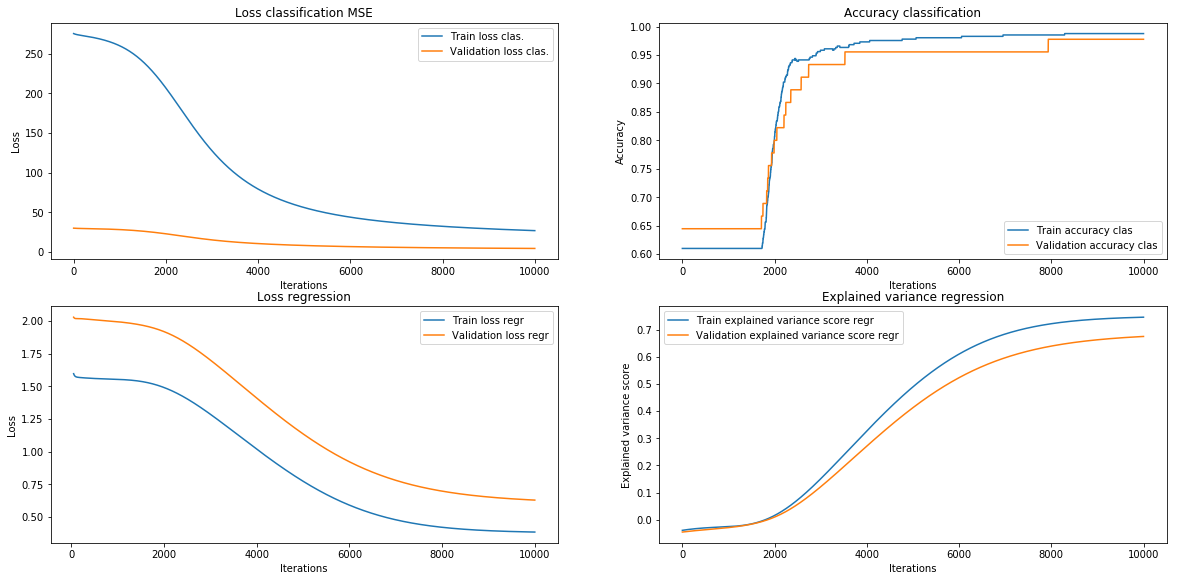



Iteration 20000


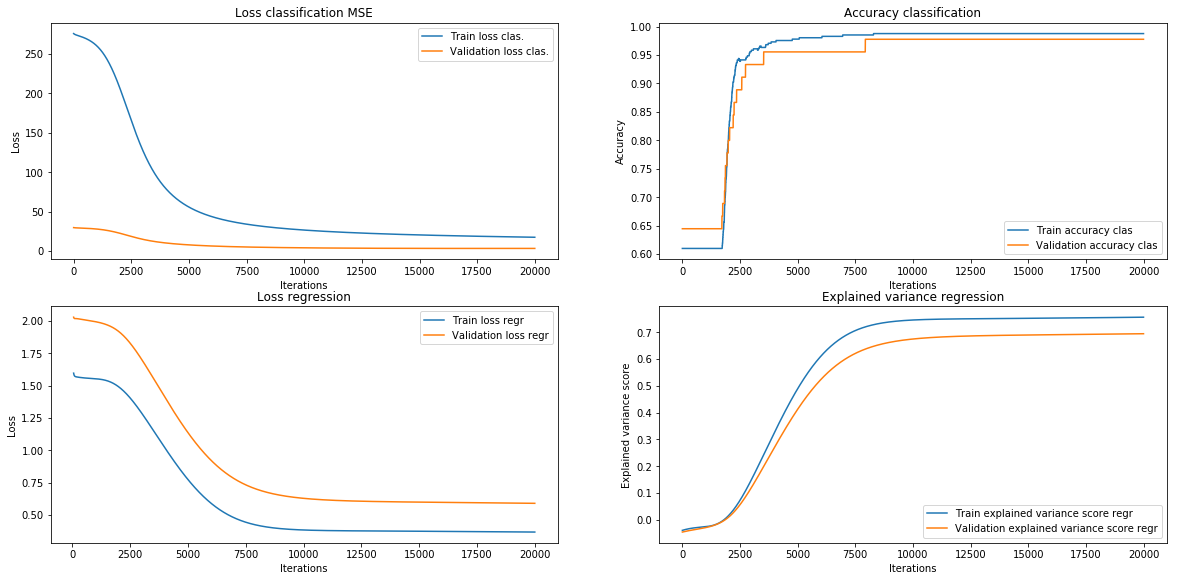



Iteration 30000


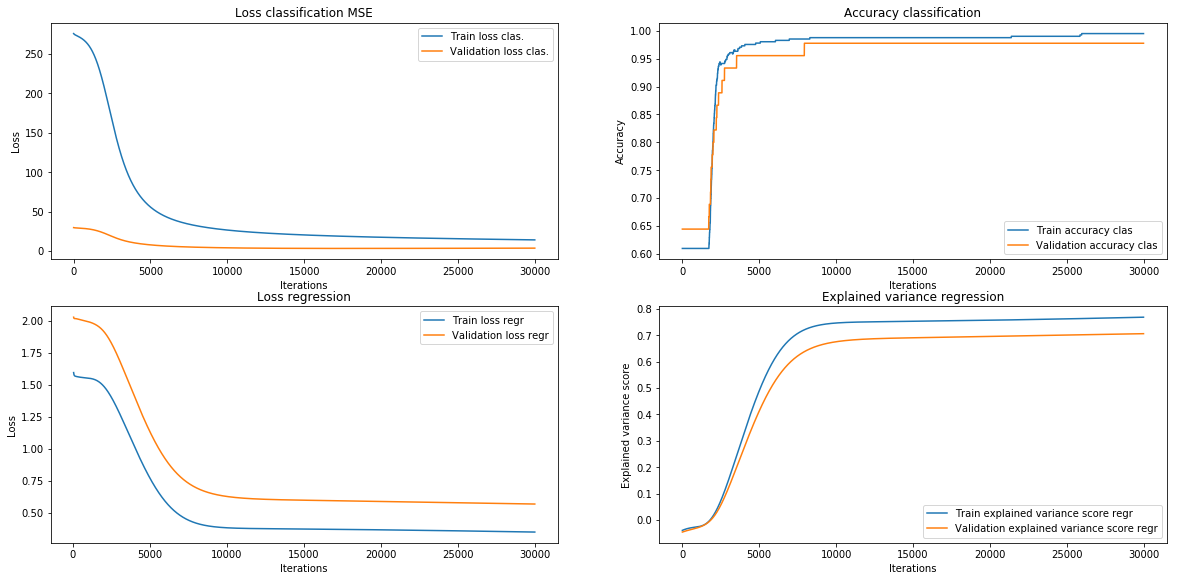



Iteration 40000


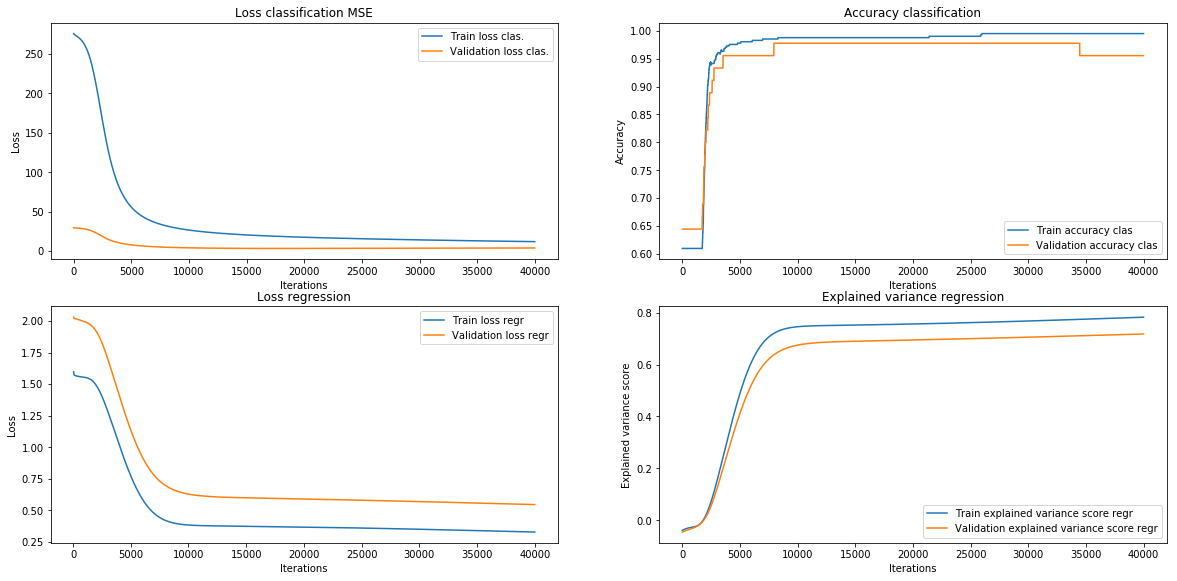

In [25]:
regr_param = [29, 8, 4, 1]
clas_param = [29, 8, 4, 2]

nn_breast = NeuralNetwork(clas_param, regr_param, 0.01, 0.00001)
nn_breast.train_hybrid(x_tr_breast, y_tr_breast_clas.reshape(len(y_tr_breast_clas), -1), y_tr_breast_regr.reshape(len(y_tr_breast_regr), -1), iterations=40001, show_plot=True)

In [26]:
res_breast_test_clas = np.round(nn_breast.predict(x_test_breast, type_nn = 'clas'), 0)
res_breast_test_regr = (nn_breast.predict(x_test_breast, type_nn = 'regr') * np.max(target_breast_regr))

In [27]:
acc = np.sum(np.argmax(y_test_breast_clas, axis=1)==np.argmax(res_breast_test_clas, axis=1)) / len(y_test_breast_clas)
print('Classification accuracy = {}'.format(acc))
mse = mean_squared_error(y_test_breast_regr * np.max(target_breast_regr), res_breast_test_regr)
print('Regression mean squared error = {}'.format(mse))

Classification accuracy = 0.956140350877193
Regression mean squared error = 2.658720854319324


## BOSTON (regression)



Iteration 10000


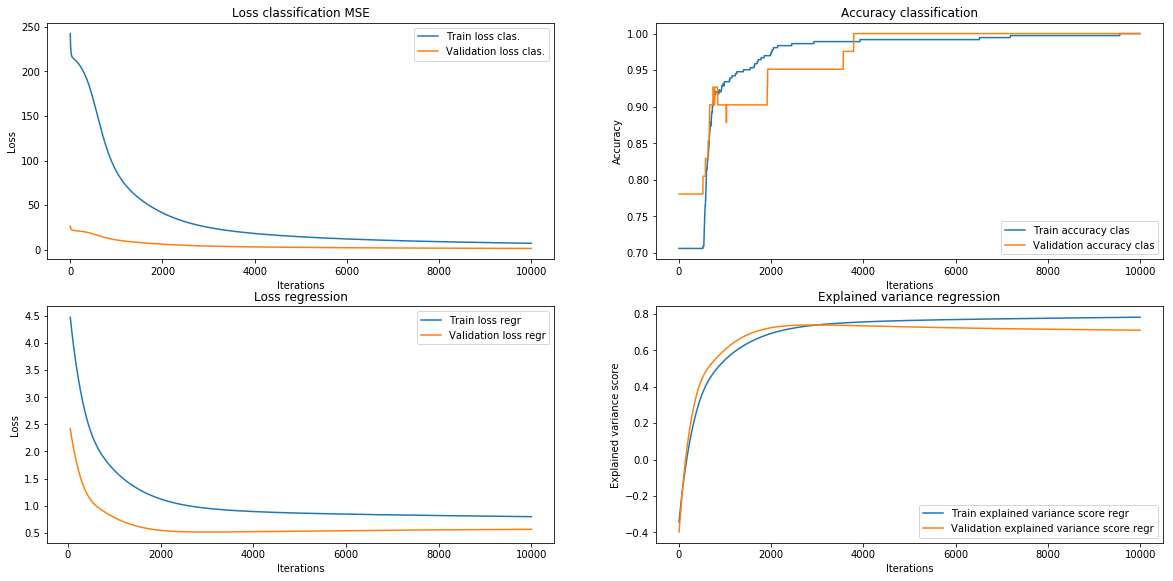



Iteration 20000


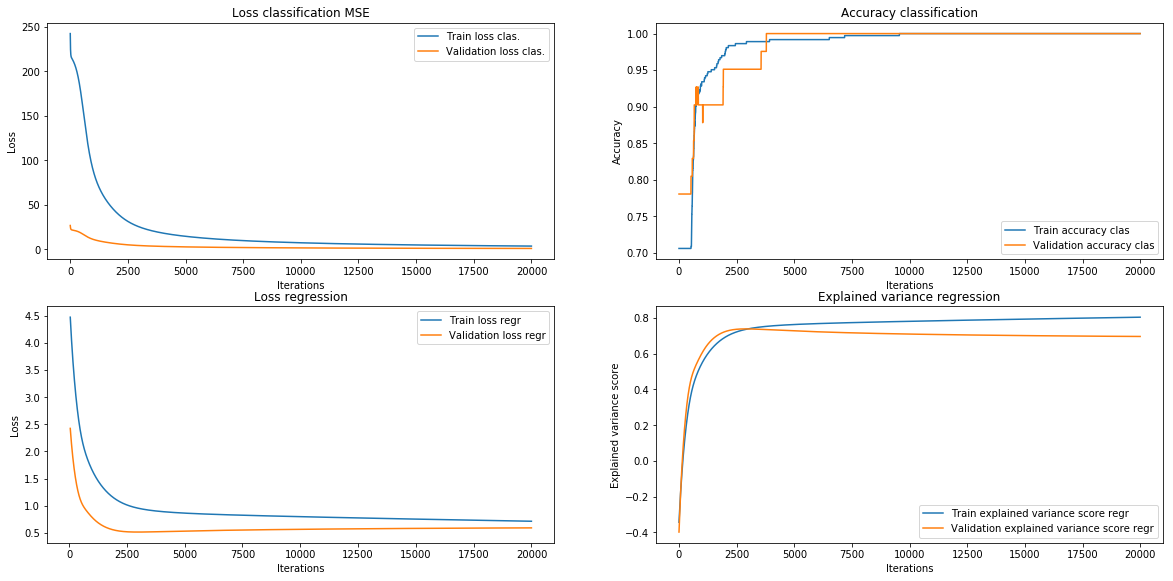



Iteration 30000


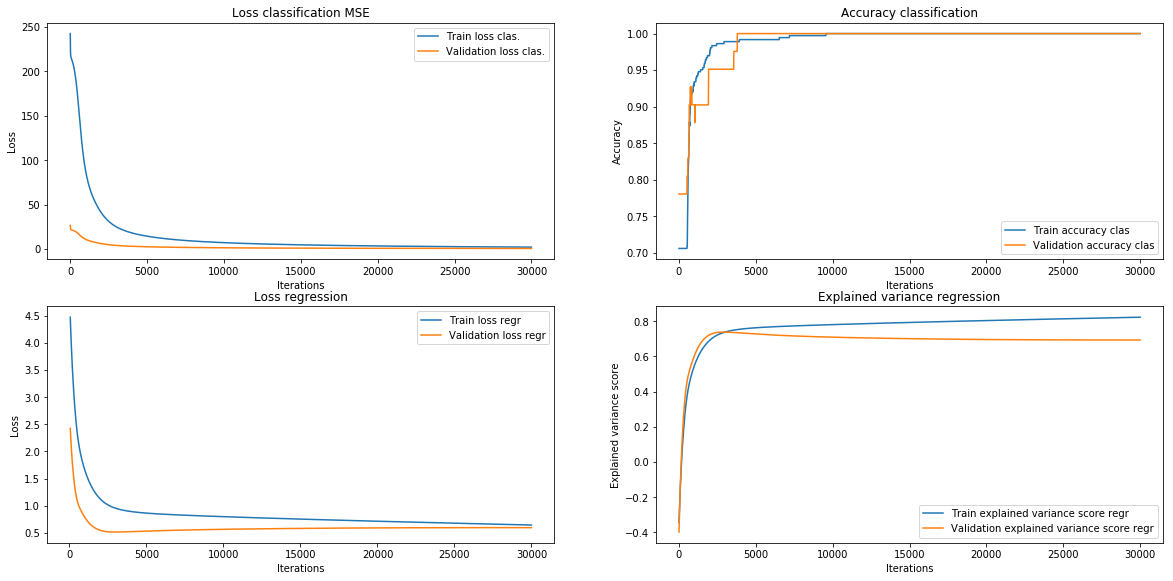

In [33]:
regr_param = [13, 16, 32, 1]
clas_param = [13, 16, 8, 2]

nn_boston = NeuralNetwork(clas_param, regr_param, 0.03, 0.00001)
nn_boston.train_hybrid(x_tr_boston, y_tr_boston_clas.reshape(len(y_tr_boston_clas), -1), y_tr_boston_regr.reshape(len(y_tr_boston_regr), -1), iterations=30001, show_plot=True)

In [34]:
res_boston_test_clas = np.round(nn_boston.predict(x_test_boston, type_nn = 'clas'), 0)
res_boston_test_regr = nn_boston.predict(x_test_boston, type_nn = 'regr') * np.max(target_boston_regr)

In [35]:
res_boston_test_regr[:10]

array([[33.02780595],
       [12.24148262],
       [36.49368899],
       [41.19465022],
       [16.61356602],
       [18.9238087 ],
       [29.42531963],
       [ 8.55959184],
       [19.98978714],
       [10.24529524]])

In [36]:
(y_test_boston_regr * np.max(target_boston_regr))[:10]

array([41.3, 12.3, 33.4, 48.5, 16.1, 19.3, 29.6,  8.4, 17.1, 13.4])

In [37]:
acc = np.sum(np.argmax(y_test_boston_clas, axis=1)==np.argmax(res_boston_test_clas, axis=1)) / len(y_test_boston_clas)
print('Classification accuracy = {}'.format(acc))
mse = mean_squared_error(y_test_boston_regr * np.max(target_boston_regr), res_boston_test_regr)
print('Regression mean squared error = {}'.format(mse))

Classification accuracy = 0.9900990099009901
Regression mean squared error = 16.765170483280997


## IRIS (multi-classification)



Iteration 10000


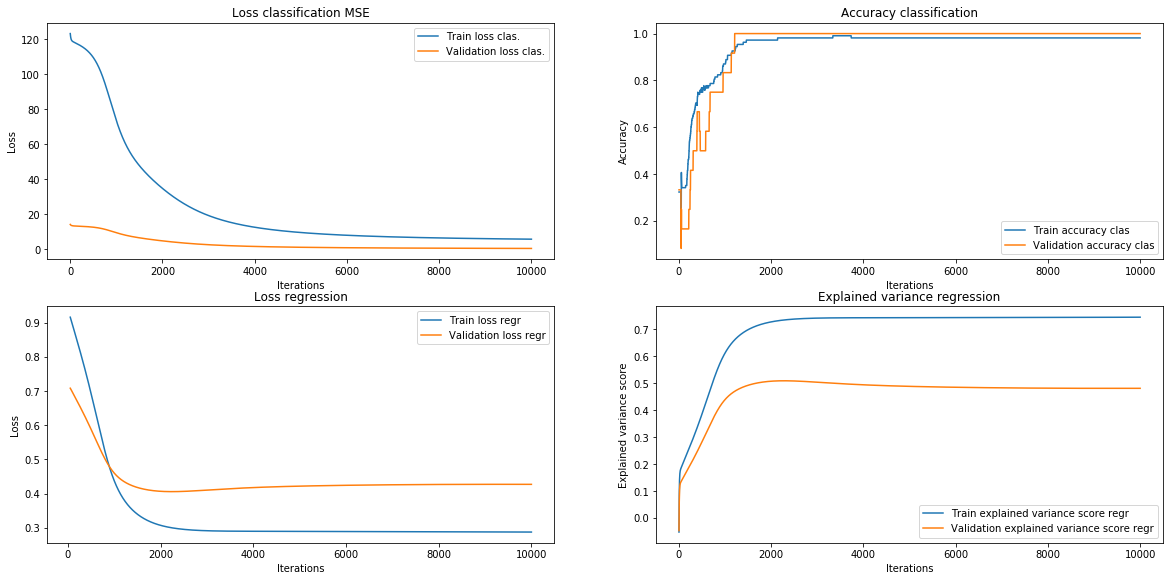



Iteration 20000


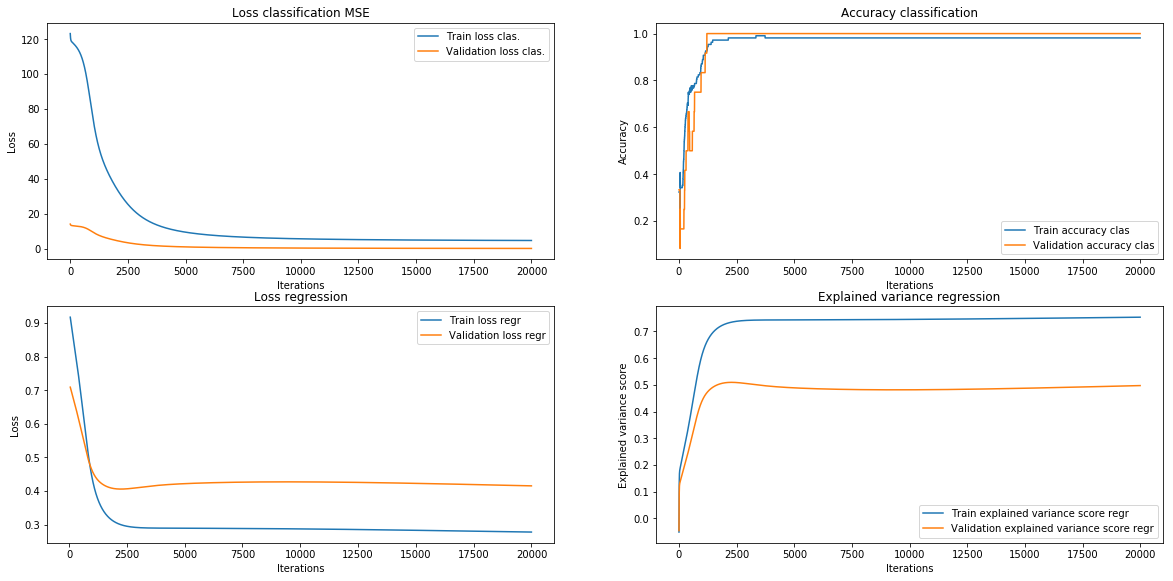



Iteration 30000


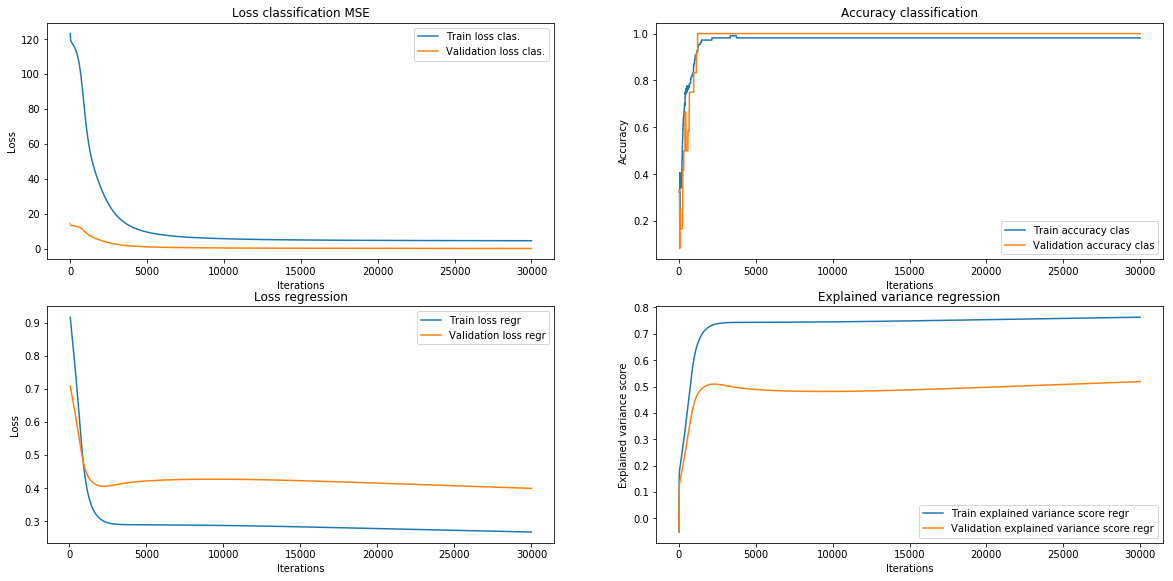

In [38]:
regr_param = [3, 8, 8, 1]
clas_param = [3, 8, 8, 3]

nn_iris = NeuralNetwork(clas_param, regr_param, 0.03, 0.00001)
nn_iris.train_hybrid(x_tr_iris, y_tr_iris_clas.reshape(len(y_tr_iris_clas), -1), y_tr_iris_regr.reshape(len(y_tr_iris_regr), -1), iterations=30001, show_plot=True)

In [39]:
res_iris_test_clas = np.round(nn_iris.predict(x_test_iris, type_nn = 'clas'), 0)
res_iris_test_regr = nn_iris.predict(x_test_iris, type_nn = 'regr') * np.max(target_iris_regr)

In [40]:
res_iris_test_clas[:5]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [41]:
y_test_iris_clas[:5]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [42]:
res_iris_test_regr[:10]

array([[5.03408255],
       [6.11722529],
       [6.54202144],
       [6.79225545],
       [5.75694208],
       [6.01862706],
       [6.35681386],
       [5.16183232],
       [6.75149622],
       [6.77391934]])

In [43]:
(y_test_iris_regr * np.max(target_iris_regr))[:10]

array([4.8, 6.1, 5.9, 7.6, 5.5, 6.6, 6.1, 5.1, 5.8, 6.5])

In [44]:
y_test_iris_clas.shape

(30, 3)

### Evaluate NN with on accuracy metric and with RMSE

In [45]:
acc = np.sum(np.argmax(y_test_iris_clas, axis=1)==np.argmax(res_iris_test_clas, axis=1)) / len(y_test_iris_clas)
print('Classification accuracy = {}'.format(acc))
mse = mean_squared_error(y_test_iris_regr * np.max(target_iris_regr), res_iris_test_regr)
print('Regression mean squared error = {}'.format(mse))

Classification accuracy = 0.9333333333333333
Regression mean squared error = 0.1865912508078308
